In [1]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import triangulate
import shapely.wkt
import pandas as pd
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import time
import random
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from sklearn.cluster import KMeans


def to_triangles(polygon):
    poly_points = []

    gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
    for geom in gdf_poly_exterior.geometry:
        poly_points += np.array(geom.coords).tolist()

    try:
        polygon.interiors[0]
    except:
        poly_points = poly_points
    else:
        gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
        for geom in gdf_poly_interior.geometry:
          poly_points += np.array(geom.coords).tolist()

    poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles

    gdf_poly_triangles = gpd.GeoDataFrame({'geometry': tri_geom}, crs=4326)

    return gdf_poly_triangles

def point_in_triangle(poly_tri):
    v1, v2, v3 = poly_tri.exterior.coords[0:3]
    v2_scaled = [v2[0] - v1[0], v2[1] - v1[1]]
    v3_scaled = [v3[0] - v1[0], v3[1] - v1[1]]
    
    s, t = random.uniform(0,1), random.uniform(0,1)
    if s+t > 1:
        s = 1 - s
        t = 1 - t
    two_weighted = [v2_scaled[0] * s, v2_scaled[1] * s]
    three_weighted = [v3_scaled[0] * t, v3_scaled[1] * t]

    new_point = np.add(np.add(two_weighted, three_weighted), [v1[0], v1[1]])
    
    return shapely.Point(new_point)

def area_dist(polys):
    total_area = sum(polys.area)
    cum_dist = []
    for i, poly in enumerate(polys):
        if i > 0:
            last_value = cum_dist[i-1]
        else:
            last_value = 0
        cum_dist.append(last_value + (poly.area / total_area))
    
    return cum_dist

def random_poly(polys):
    cum_dist = area_dist(polys)
    rand = random.random()
    index = cum_dist.index(next(x for x in cum_dist if x > rand), 0)
    return polys[index]

def tri_test(poly_dir, points=1000):
    poly_input = gpd.read_file(poly_dir)['geometry'][0]

    poly_tri_4326 = to_triangles(poly_input)
    poly_tri_3857 = poly_tri_4326.to_crs('EPSG:3857')

    triangle_points = []

    start_time = time.time()

    num_tri = len(poly_tri_3857['geometry'])

    for i in range(points):
        tri = random_poly(poly_tri_3857['geometry']) 
        x = point_in_triangle(tri)
        triangle_points.append(x)

    triangle_points = gpd.GeoDataFrame(pd.DataFrame(triangle_points, columns=['geometry']), geometry='geometry')
    end_time = time.time()

    fig, ax = plt.subplots(1,3, figsize=(15,10))

    poly_tri_3857.plot(ax=ax[0], facecolor='none', edgecolor='black')

    poly_tri_3857.plot(ax=ax[1], facecolor='none', edgecolor='black')
    triangle_points.plot(ax=ax[1], color='red', markersize=0.5)

    triangle_points.plot(ax=ax[2], color='red', markersize=0.5)

    plt.show()

    print("Time taken for generation: ", end_time - start_time)

#tri_test("scenarios/kildare/kildare.geojson", 5000)

Now we have chosen our triangle. How do we go about generating a random point inside of it? Alpha Wolfram has a great post about this. The gist of it: We assume one point of the triangle to be at the origin of our coordinate system [0, 0]. For the other two points we create two random weights in the range of [0, 1]. We multiply (scale) each point by one of the weights and add both points up. Tada random points!

Original gen from wolframalpha explanation, limiting points in the triangle comes from the Points with Triangulation paper


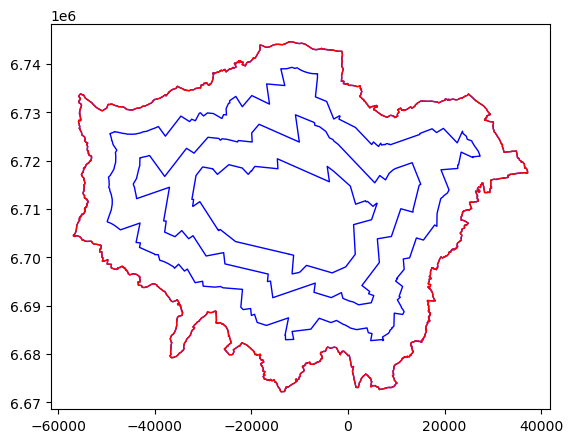

In [2]:
from shapely.geometry import box

def point_in_poly(poly):
    minX, minY, maxX, maxY = poly.bounds
    new_point = shapely.Point([random.uniform(minX, maxX), random.uniform(minY, maxY)])
    return new_point

def points_in_poly(poly, points):
    points_list = []
    for i in range(points):
        points_list.append(point_in_poly(poly))
    points_gdf = gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry', crs=4326)
    return points_gdf

def points_in_poly_check(poly, points):
    points_list = []
    rejects = 0
    while len(points_list) < points:
        new_point = point_in_poly(poly)
        if new_point.within(poly):
            points_list.append(new_point)
        else:
            rejects += 1
    points_gdf = gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry', crs=4326)
    print(f"Total number of rejections: {rejects}\nRejection rate: {round((points/rejects)*100,2)}%")
    return points_gdf

def uniform_test(file_dir, points=500):
    source_poly = gpd.read_file(file_dir)
    points_gdf = points_in_poly(source_poly, points)

def bounding_ratio(file_dir, points):
    source_poly = gpd.read_file(file_dir)#.to_crs(3857)
    minX, minY, maxX, maxY = source_poly.bounds.loc[0]

    source_bb = gpd.GeoSeries(box(minX, minY, maxX, maxY), crs=4326)

    one_join_start = time.time()
    # Generating points with a spatial join at the end to remove rejects
    source_bb_points = points_in_poly(source_bb[0], points * 2)#.to_crs(3857)
    source_points_sjoin = source_bb_points.sjoin(source_poly, predicate='within')
    one_join_end = time.time()

    # generating points with the within function at each generation
    every_start = time.time()
    source_points_every = points_in_poly_check(source_poly['geometry'][0], points)
    every_end = time.time()

    source_poly_area = source_poly['geometry'][0].area
    source_bb_area = source_bb.area

    print(f"Useable area in bounding box: {round((source_poly_area / source_bb_area[0])*100, 2)} %")

    fig, ax = plt.subplots(1,2, figsize=(10,5))

    source_bb_points.plot(ax=ax[0], color='green', markersize=0.5)

    for x in ax:
        source_poly.plot(ax=x, alpha=0.5)
        source_bb.plot(ax=x, facecolor='none', edgecolor='red')


    source_points_sjoin.plot(ax=ax[0], color='red', markersize=0.5)
    source_points_every.plot(ax=ax[1], color='pink', markersize=0.5)
    ax[0].set_title(f'Spatial Join after Generation - {len(source_points_sjoin)}\nTime taken:{round(one_join_end - one_join_start, 2)} seconds')
    ax[1].set_title(f'Within Statements for each Point - {len(source_points_every)}\nTime taken:{round(every_end - every_start, 2)} seconds')


    plt.show()

    print(f"Time taken to generate {len(source_points_sjoin)} points with SJOIN: {round(one_join_end - one_join_start, 2)}")
    print(f"Time taken to generate {len(source_points_every)} points with within checks: {round(every_end - every_start, 2)}")

